# Prediction of aging parameters for partial data window

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
plt.style.use('seaborn-white')

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
parameter_values.search("Li")

Cell cooling surface area [m2]	0.41
Initial plated lithium concentration [mol.m-3]	0.0
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Lithium interstitial reference concentration [mol.m-3]	15.0
Lithium metal partial molar volume [m3.mol-1]	1.3e-05
Typical lithium ion diffusivity [m2.s-1]	5.34e-10
Typical plated lithium concentration [mol.m-3]	1000.0


In [7]:
cell = 1

## Load eSOH Data and OCV Data

In [8]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 18, 57, 93, 134, 175, 216, 257, 298, 339


In [9]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " until 3V"
elif cell_no=='04':
    c_rate_c = '1.5C'
    c_rate_d = '1.5C'
    dis_set = " until 3V"
elif cell_no=='07':
    c_rate_c = '2C'
    c_rate_d = '2C'
    dis_set = " until 3V"
elif cell_no=='10':
    c_rate_c = 'C/5'
    c_rate_d = '1.5C'
    dis_set = " until 3V"
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"
elif cell_no=='16':
    c_rate_c = 'C/5'
    c_rate_d = '1.5C'
    dis_set = " for 20 min"

In [10]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [11]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.n.L * param.n.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.p.L * param.p.c_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.p.c_max)

In [12]:
eps_p_data

0.43573014063297083

In [13]:
parameter_values = get_parameter_values()
sim_des = '_highc'
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 1*8e-7,
        "Negative electrode LAM constant proportional term [s-1]": 1*5.5e-6,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=2)

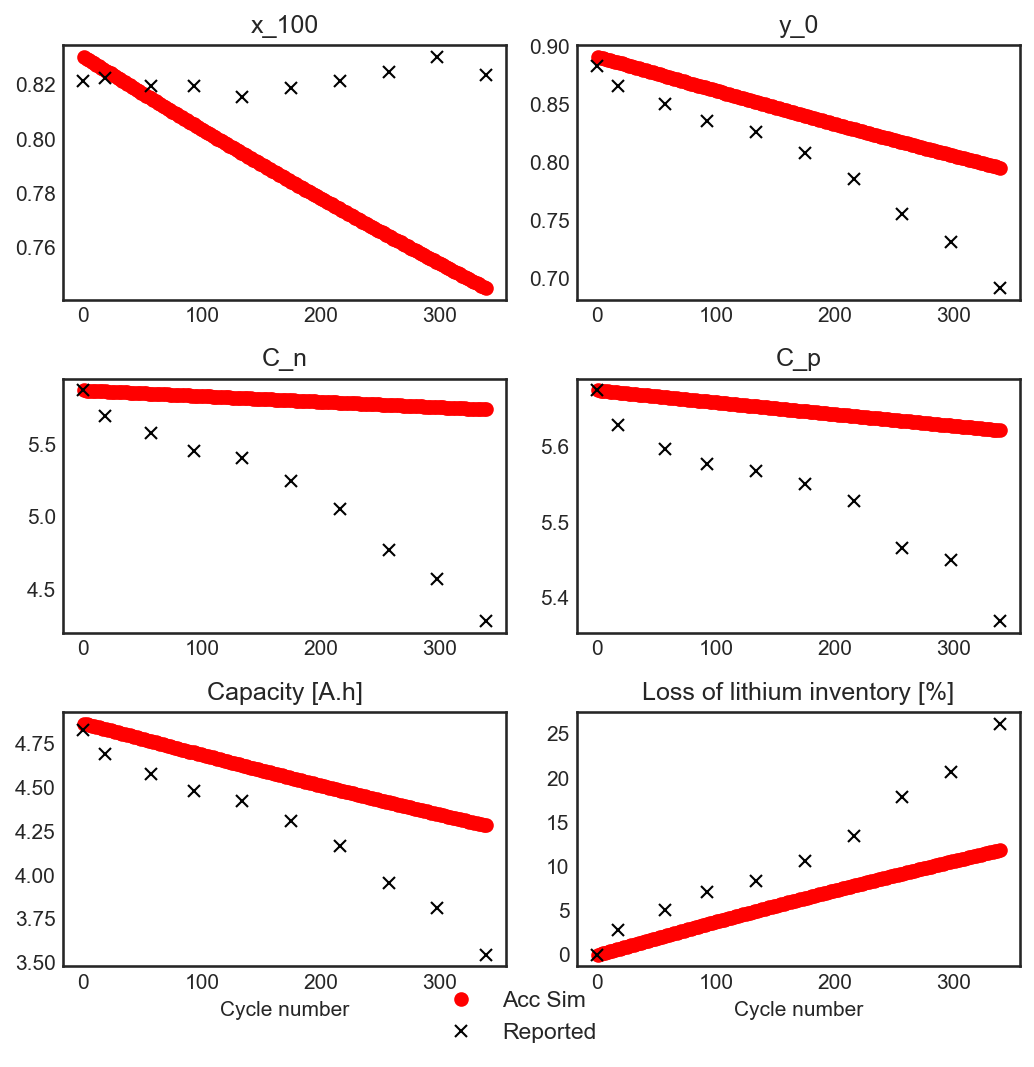

In [14]:
fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [15]:
# fgdfdfg

# Parameter Fitting

In [16]:
cycles = np.array(dfe['N'].astype('int'))
cycles=cycles-1
cycles[0]=cycles[0]+1
cycles
dfe['N_mod'] = cycles

In [17]:
# dfe

In [18]:
def plot_comp(all_sumvars_dict_0,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict_0["Cycle number"],all_sumvars_dict_0[name],"ro")
        # ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.axvline(x = all_sumvars_dict_0["Cycle number"][-1], color = 'm', label = 'axvline - full height')
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Train"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5, -0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

## List of Initial Conditions

In [19]:
ic = 0
blam_p = [1*8e-7,1/10*8e-7,1/5*8e-7]
blam_n = [1*5.5e-6,1/10*5.5e-6,1/2*5.5e-6]
k_sei= [1*2e-16,1/5*2e-16,5*2e-16]

In [20]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Cap"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    # variables = ["Capacity [A.h]", "C_n"]
    weights = [1,1,5,5]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,expt,ic):
    parameter_values = get_parameter_values()
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]":  1.6827e-16,
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "EC diffusivity [m2.s-1]": 2e-18,
            "Positive electrode LAM constant exponential term": 2,
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
        },
        check_already_exists=False,
    )
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    return cycle_adaptive_simulation(spm, parameter_values, expt,save_at_cycles=1)
def prediction_error(x,data,expt,ic):
    try:
        model = simulate(x,expt,ic,timeout=60)
        out = multi_objective(pd.DataFrame(model), data)
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out = 10*np.ones_like(np.concatenate([np.array(data['Cap'])]*4))
        print(f"x={x}, norm={np.linalg.norm(out)}")
        return out
    return out
def train_model(data,expt,ic):
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0])
    # print(prediction_error(x0))
    soln_dfols = dfols.solve(prediction_error, x0,args=(data,expt,ic), rhoend=1e-3)
    print(timer.time())
    return soln_dfols
def sim_train(dfe,experiment,df,train_len,ic):
    data_train = dfe.iloc[:train_len]
    # experiment_train = pybamm.Experiment(
    #     [
    #         ("Discharge at "+c_rate_d+dis_set,
    #         "Rest for 5 min",
    #         "Charge at "+c_rate_c+" until 4.2V", 
    #         "Hold at 4.2V until C/50")
    #     ] *data_train.N.iloc[-1],
    #     termination="50% capacity",
    # #     cccv_handling="ode",
    # )
    experiment_train=experiment
    soln_dfols = train_model(data_train,experiment_train,ic)
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['train_len'][0]=train_len
    df['x_0'][0]=round(xsol[0],4)*blam_p[ic]
    df['x_1'][0]=round(xsol[1],4)*blam_n[ic]
    # df['obj'][0]=soln_dfols.f
    try:
        sol_out = simulate(soln_dfols.x,experiment_train,ic,timeout = 60)
        sol_full = simulate(soln_dfols.x,experiment,ic,timeout = 60)
        print('err 0')
        df['obj'][0]= np.linalg.norm(prediction_error(soln_dfols.x,data_train,experiment_train,ic))
        print('err 1')
        # df['obj_full'][0] = np.linalg.norm(prediction_error(soln_dfols.x,dfe,experiment,ic))
        # print('err 2')
        fig = plot_comp(sol_out,dfe);
        return df,fig
    except:
        print("Train Len = "+str(train_len)+" failed")
        fig, axes = plt.subplots(3,2,figsize=(7,7))
        return df,fig

In [21]:
df_x = pd.DataFrame(columns=['train_len','x_0','x_1','obj'], index=range(1))

In [22]:
df_x

train_len  x_0  x_1  obj
0       NaN  NaN  NaN  NaN

In [23]:
sim_des = "cell_"+cell_no
print(sim_des)

cell_01


In [24]:
blam_n

[5.5e-06, 5.5e-07, 2.75e-06]

Initial Condition = 0
x=[1. 1.], norm=2.666864592704795
x=[1.1 1. ], norm=2.6673004883086557
x=[1.  1.1], norm=2.64075366631847
x=[0.99847156 1.19998832], norm=2.6144396932636464
x=[0.99263932 1.5999458 ], norm=2.5085210297405482
x=[0.97383432 3.19983529], norm=2.07439222144547
x=[2.43458687 9.43090277], norm=0.5196667654792967
x=[3.70677561 8.73276941], norm=0.5303192476797599
x=[2.02393623 8.68258567], norm=0.5912021950523522
x=[3.88562176 9.44966724], norm=0.4555276470158166
x=[5.0596539  9.54081712], norm=0.43830113565158507
x=[4.89788775 9.81165497], norm=0.4517014210002569
x=[5.18843209 9.61773381], norm=0.4392813911179009
x=[5.05052322 9.54035381], norm=0.4382982175428202
x=[5.04340069 9.54092774], norm=0.43829769610345926
x=[5.04350277 9.55592739], norm=0.4383345728786414
x=[5.04418098 9.54096696], norm=0.43829734326938746
x=[5.04327141 9.54081159], norm=0.43829770056683276
x=[5.04434935 9.53998124], norm=0.4382975315950789
x=[5.04516799 9.54112761], norm=0.4382973741153696
6 m

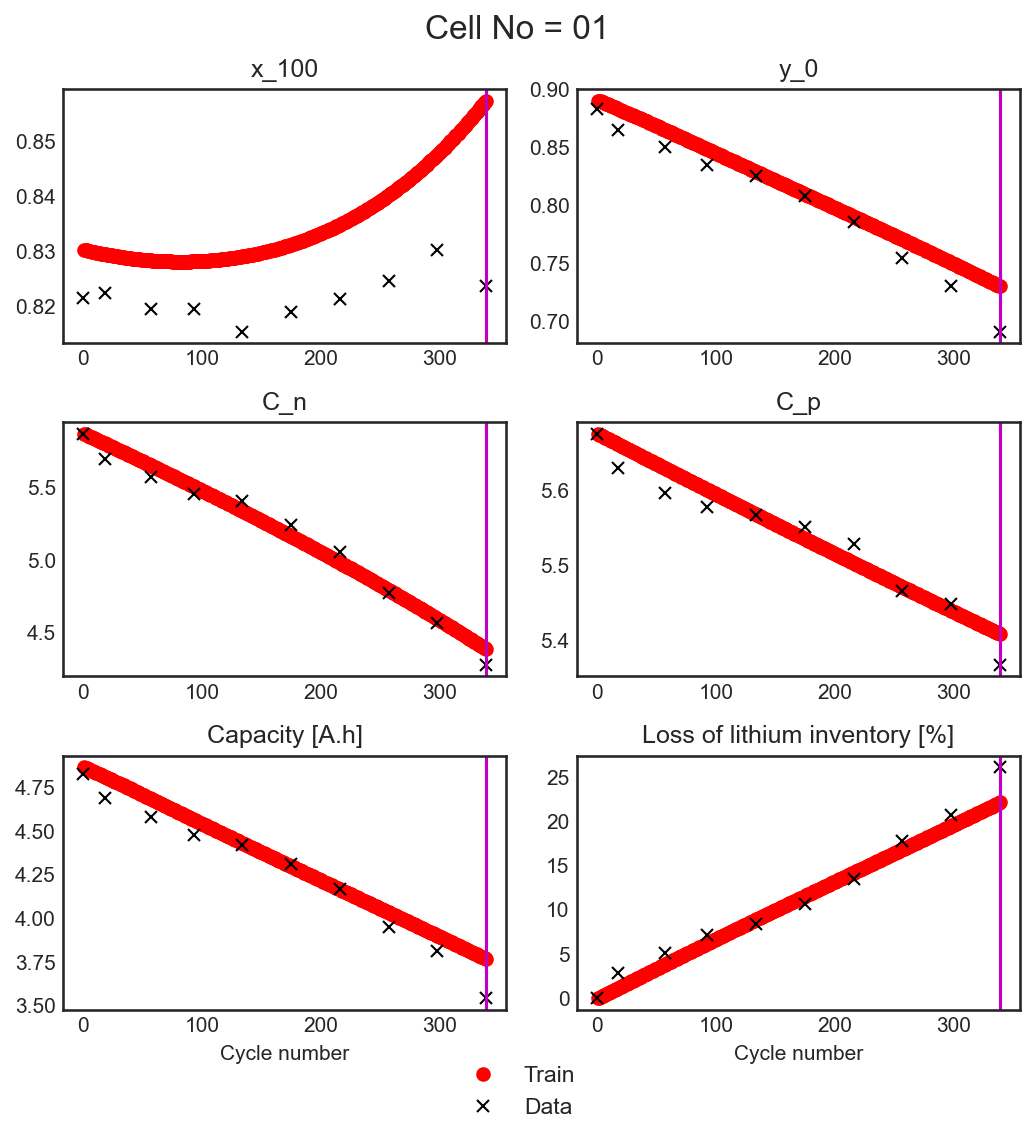

In [25]:
sim_des = "cell_"+cell_no
timer1 = pybamm.Timer()
train_len = len(N)
# for ic in range(0,3):
for ic in [0]:
    print("Initial Condition = {0}".format(ic))
    df_x,fig = sim_train(dfe,experiment,df_x,train_len,ic)
    df_x.to_csv(res_DIR + "fit_train_beta_"+sim_des+'_ic'+str(ic)+".csv", index=False)
    fig.suptitle('Cell No = '+cell_no,fontsize=16,y=1.02)
    fig.savefig(fig_DIR + "fit_train_beta_"+ sim_des+'_ic'+str(ic)+"_eSOHC.png",bbox_inches='tight')
    print('Total Time')
    print(timer1.time())

## Results

In [25]:
sim_des

'cell_04'

In [27]:
df_x['x_0']

0    0.000004
Name: x_0, dtype: object

In [26]:
df_x

train_len       x_0       x_1       obj
0        10  0.000004  0.000052  0.438297